In [1]:
!pip install vllm matplotlib autoawq accelerate

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [2]:
from vllm import LLM, SamplingParams
import time

In [3]:
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]
max_tokens = 10
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=max_tokens)

In [4]:
model = "/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct"
llm = LLM(model=model, gpu_memory_utilization=0.9)

INFO 03-15 02:17:03 __init__.py:207] Automatically detected platform cuda.
INFO 03-15 02:17:11 config.py:549] This model supports multiple tasks: {'embed', 'classify', 'reward', 'score', 'generate'}. Defaulting to 'generate'.
INFO 03-15 02:17:11 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=Observab

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 03-15 02:18:14 model_runner.py:1115] Loading model weights took 14.2487 GB
INFO 03-15 02:18:18 worker.py:267] Memory profiling takes 3.27 seconds
INFO 03-15 02:18:18 worker.py:267] the current vLLM instance can use total_gpu_memory (23.64GiB) x gpu_memory_utilization (0.90) = 21.28GiB
INFO 03-15 02:18:18 worker.py:267] model weights take 14.25GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 4.35GiB; the rest of the memory reserved for KV Cache is 2.60GiB.
INFO 03-15 02:18:18 executor_base.py:111] # cuda blocks: 3044, # CPU blocks: 4681
INFO 03-15 02:18:18 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 1.49x
INFO 03-15 02:18:21 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_ut

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]

INFO 03-15 02:18:39 model_runner.py:1562] Graph capturing finished in 18 secs, took 0.21 GiB
INFO 03-15 02:18:39 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 24.60 seconds


## FP16

In [5]:
# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs={batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompt = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]

    outputs = llm.generate(batch_prompt, sampling_params)

    duration_s = time.time() - t0

    # calculate throughput
    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"duration: {duration_s}")
    print(f"throughput: {throughput} tokens/s")
    print(f"avg latency: {avg_latency}")
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)


bs=1


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s, est. speed input: 23.22 toks/s, output: 46.44 toks/s]


duration: 0.2218303680419922
throughput: 45.079490640826116 tokens/s
avg latency: 0.022183036804199217

bs=2


Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 10.06it/s, est. speed input: 60.36 toks/s, output: 100.60 toks/s]


duration: 0.20243406295776367
throughput: 98.79760208227826 tokens/s
avg latency: 0.020243406295776367

bs=4


Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 20.29it/s, est. speed input: 111.63 toks/s, output: 202.95 toks/s]


duration: 0.2006375789642334
throughput: 199.36444711152834 tokens/s
avg latency: 0.02006375789642334

bs=8


Processed prompts: 100%|██████████| 8/8 [00:00<00:00, 39.85it/s, est. speed input: 219.43 toks/s, output: 398.95 toks/s]


duration: 0.20479607582092285
throughput: 390.6324849210165 tokens/s
avg latency: 0.020479607582092284

bs=16


Processed prompts: 100%|██████████| 16/16 [00:00<00:00, 76.44it/s, est. speed input: 420.55 toks/s, output: 764.62 toks/s]


duration: 0.21404075622558594
throughput: 747.5211862518825 tokens/s
avg latency: 0.021404075622558593

bs=32


Processed prompts: 100%|██████████| 32/32 [00:00<00:00, 133.77it/s, est. speed input: 736.00 toks/s, output: 1338.15 toks/s]


duration: 0.24671339988708496
throughput: 1297.0515592037425 tokens/s
avg latency: 0.024671339988708497

bs=64


Processed prompts: 100%|██████████| 64/64 [00:00<00:00, 219.41it/s, est. speed input: 1207.06 toks/s, output: 2194.59 toks/s]


duration: 0.303372859954834
throughput: 2109.615211114412 tokens/s
avg latency: 0.0303372859954834

bs=128


Processed prompts: 100%|██████████| 128/128 [00:00<00:00, 310.14it/s, est. speed input: 1706.11 toks/s, output: 3101.95 toks/s]

duration: 0.4336862564086914
throughput: 2951.4423874059103 tokens/s
avg latency: 0.04336862564086914



In [6]:
# save observations and restart kernel
# save as json
import json

data = {
    "durations": durations,
    "throughputs": throughputs,
    "latencies": latencies,
    "batch_sizes": batch_sizes,
    "prompts": prompts,
    "max_tokens": max_tokens

}

with open("basic_fp16_inference_observation.json", "w") as f:
    json.dump(data, f)

In [1]:
import json

# Read the data from the JSON file
with open("basic_fp16_inference_observation.json", "r") as f:
    data = json.load(f)

# Restore the lists
durations = data["durations"]
throughputs = data["throughputs"]
latencies = data["latencies"]
batch_sizes = data["batch_sizes"]
prompts = data["prompts"]
max_tokens = data["max_tokens"]

## AWQ

In [2]:
from vllm import LLM, SamplingParams
import matplotlib.pyplot as plt
import time

In [3]:
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=max_tokens)

In [4]:
model = "/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct-AWQ"
# Create an LLM.
llm_awq = LLM(model=model, quantization="awq_marlin", gpu_memory_utilization=0.9)

INFO 03-15 02:19:43 __init__.py:207] Automatically detected platform cuda.
INFO 03-15 02:19:50 config.py:549] This model supports multiple tasks: {'classify', 'score', 'generate', 'embed', 'reward'}. Defaulting to 'generate'.
INFO 03-15 02:19:51 awq_marlin.py:114] The model is convertible to awq_marlin during runtime. Using awq_marlin kernel.
INFO 03-15 02:19:51 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct-AWQ', speculative_config=None, tokenizer='/root/autodl-fs/data2/root/.cache/modelscope/hub/Qwen/Qwen2-7B-Instruct-AWQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=awq_marlin, enforce_eager=False, kv_cach

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 03-15 02:20:14 model_runner.py:1115] Loading model weights took 5.2048 GB
INFO 03-15 02:20:18 worker.py:267] Memory profiling takes 3.70 seconds
INFO 03-15 02:20:18 worker.py:267] the current vLLM instance can use total_gpu_memory (23.64GiB) x gpu_memory_utilization (0.90) = 21.28GiB
INFO 03-15 02:20:18 worker.py:267] model weights take 5.20GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 5.51GiB; the rest of the memory reserved for KV Cache is 10.48GiB.
INFO 03-15 02:20:18 executor_base.py:111] # cuda blocks: 12268, # CPU blocks: 4681
INFO 03-15 02:20:18 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 5.99x
INFO 03-15 02:20:21 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_ut

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:18<00:00,  1.91it/s]

INFO 03-15 02:20:39 model_runner.py:1562] Graph capturing finished in 18 secs, took 0.27 GiB
INFO 03-15 02:20:39 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 25.39 seconds


In [5]:
# observations
durations_with_awq = []
throughputs_with_awq = []
latencies_with_awq = []

for batch_size in batch_sizes:
    print(f"bs={batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompt = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]

    outputs = llm_awq.generate(batch_prompt, sampling_params)

    duration_s = time.time() - t0

    # calculate throughput
    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"duration: {duration_s}")
    print(f"throughput: {throughput} tokens/s")
    print(f"avg latency: {avg_latency}")
    print()

    durations_with_awq.append(duration_s)
    throughputs_with_awq.append(throughput)
    latencies_with_awq.append(avg_latency)

bs=1


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s, est. speed input: 40.99 toks/s, output: 81.96 toks/s]


duration: 0.12714529037475586
throughput: 78.65018020349306 tokens/s
avg latency: 0.012714529037475586

bs=2


Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 19.78it/s, est. speed input: 118.80 toks/s, output: 197.97 toks/s]


duration: 0.10377669334411621
throughput: 192.7214999391184 tokens/s
avg latency: 0.01037766933441162

bs=4


Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 45.87it/s, est. speed input: 252.70 toks/s, output: 459.41 toks/s]


duration: 0.09054708480834961
throughput: 441.75911443933626 tokens/s
avg latency: 0.00905470848083496

bs=8


Processed prompts: 100%|██████████| 8/8 [00:00<00:00, 87.42it/s, est. speed input: 481.50 toks/s, output: 875.39 toks/s]


duration: 0.09540367126464844
throughput: 838.542153981487 tokens/s
avg latency: 0.009540367126464843

bs=16


Processed prompts: 100%|██████████| 16/16 [00:00<00:00, 160.87it/s, est. speed input: 885.65 toks/s, output: 1610.17 toks/s]


duration: 0.1044931411743164
throughput: 1531.200978378921 tokens/s
avg latency: 0.01044931411743164

bs=32


Processed prompts: 100%|██████████| 32/32 [00:00<00:00, 240.28it/s, est. speed input: 1322.33 toks/s, output: 2404.10 toks/s]


duration: 0.14169931411743164
throughput: 2258.303097605707 tokens/s
avg latency: 0.014169931411743164

bs=64


Processed prompts: 100%|██████████| 64/64 [00:00<00:00, 329.13it/s, est. speed input: 1811.07 toks/s, output: 3292.74 toks/s]


duration: 0.20654606819152832
throughput: 3098.5823434147082 tokens/s
avg latency: 0.02065460681915283

bs=128


Processed prompts: 100%|██████████| 128/128 [00:00<00:00, 358.00it/s, est. speed input: 1969.46 toks/s, output: 3580.76 toks/s]

duration: 0.3790445327758789
throughput: 3376.9119175156056 tokens/s
avg latency: 0.03790445327758789



In [6]:
def render_plot(x, y1, y2, y3, y4, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()

    # plot the first line (FP32 throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color, label='FP16 Throughput', linestyle='-')
    ax1.tick_params(axis='y', labelcolor=color)

    # plot the third line (AWQ throughput)
    ax1.plot(x, y3, color=color, label='AWQ Throughput', linestyle='--')

    # set the x-axis to be log scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(x, y2, color=color, label='FP16 Latency', linestyle='-')
    ax2.tick_params(axis='y', labelcolor=color)

    # plot the fourth line (AWQ latency)
    ax2.plot(x, y4, color=color, label='AWQ Latency', linestyle='--')

    # Add legends
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

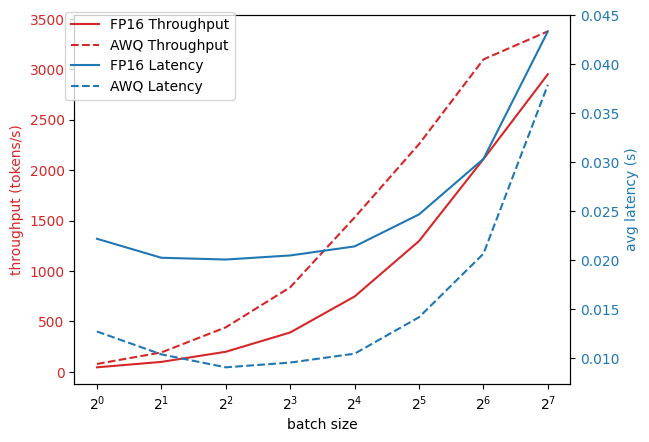

In [7]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    throughputs_with_awq,
    latencies_with_awq,
    "batch size",
    "throughput (tokens/s)",
    "avg latency (s)"
)

In [ ]:
# save observations and restart kernel
# save as json
import json

data = {
    "durations": durations_with_awq,
    "throughputs": throughputs_with_awq,
    "latencies": latencies_with_awq,
    "batch_sizes": batch_sizes,
    "prompts": prompts,
    "max_tokens": max_tokens

}

with open("int4_awq_inference_observation.json", "w") as f:
    json.dump(data, f)